<a href="https://colab.research.google.com/github/NataliaGon/MachineLearning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Step 1. Завантажити дані, вивести назви колонок і розмір датасета

In [5]:
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-cybersecurity-threats-2015-2024' dataset.
Path to dataset files: /kaggle/input/global-cybersecurity-threats-2015-2024


In [6]:
df = pd.read_csv(os.path.join(path, "Global_Cybersecurity_Threats_2015-2024.csv"))

print("Назви колонок:")
for col in df.columns:
    print(col)

print("\n")

print("Size rows/columns:", df.shape)

Назви колонок:
Country
Year
Attack Type
Target Industry
Financial Loss (in Million $)
Number of Affected Users
Attack Source
Security Vulnerability Type
Defense Mechanism Used
Incident Resolution Time (in Hours)


Size rows/columns: (3000, 10)


# Step 2. Опрацювати пропуски (по можливості заповнити їх або видалити)

In [7]:
print(df.isnull().sum())

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64


Пропусків немає.

# Step 3. Візуалізувати дані

- побудувати графік (heatmap), що відображає кореляції
ознак між собою і з цільовою змінною (розміткою);
- побудувати гістограми
розподілу ознак і boxplot-и ознак відносно цільової змінної (якщо ознак занадто багато
обмежитися декількома)

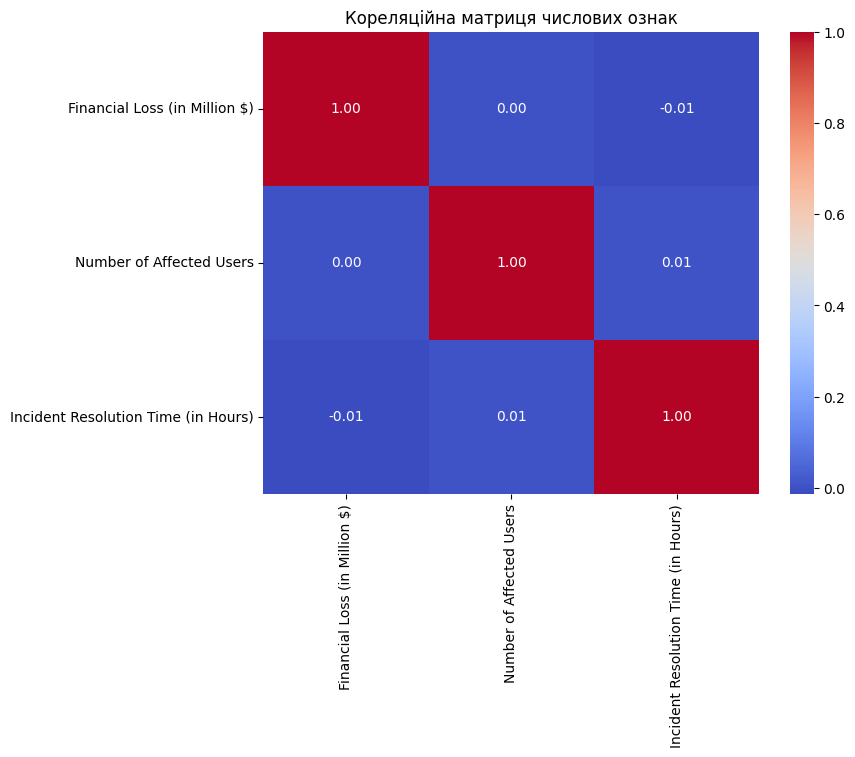

In [8]:
corr = df.drop(columns=["Year"]).corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця числових ознак")
plt.show()


Між числовими значеннями кореляції немає

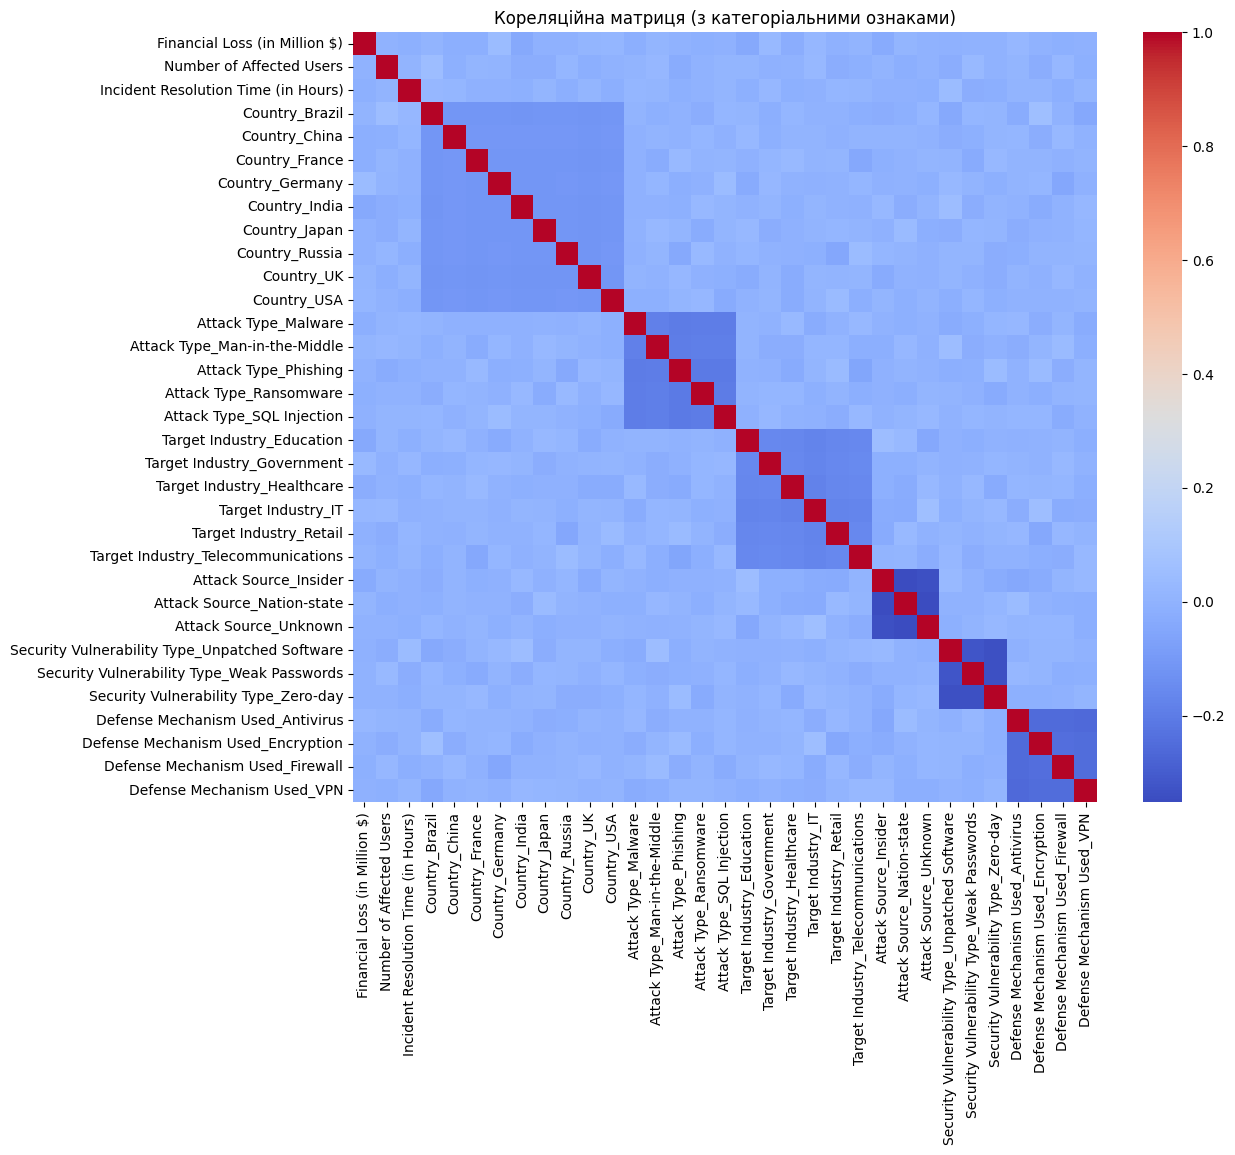

In [9]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df.drop(columns=["Year"]), drop_first=True)

corr = df_encoded.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Кореляційна матриця (з категоріальними ознаками)")
plt.show()

Між числовими та категоріальними значеннями кореляції немає

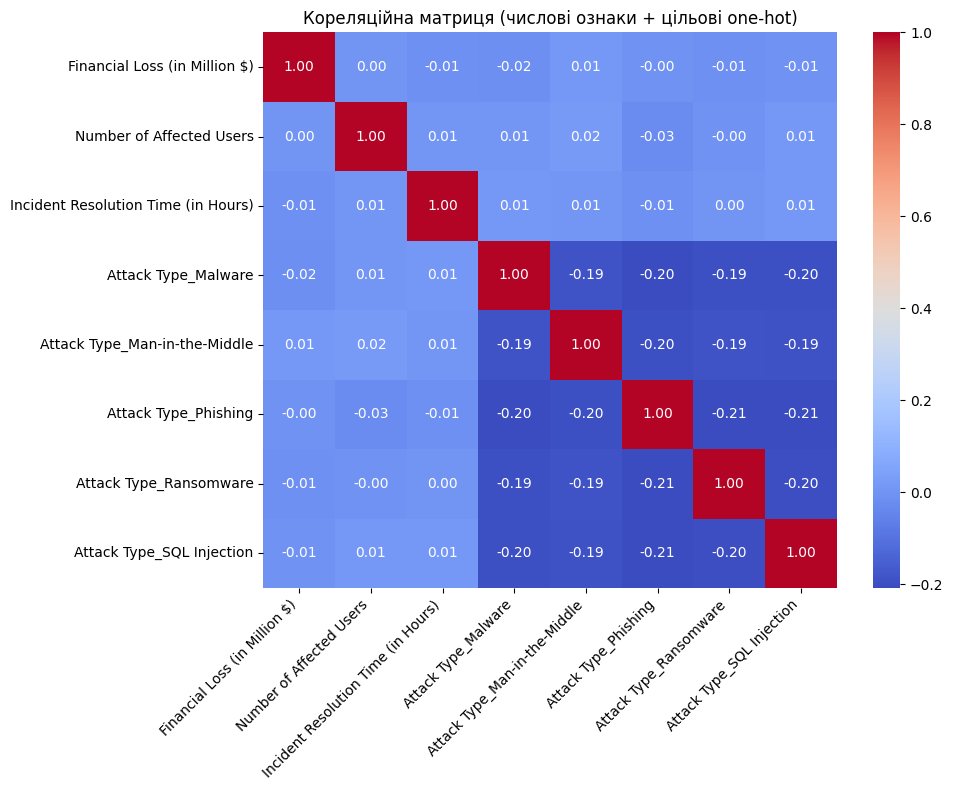

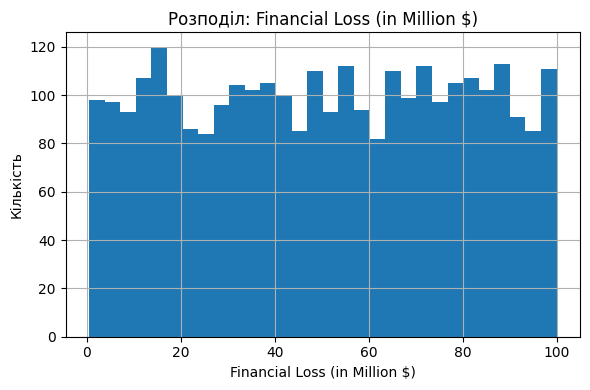

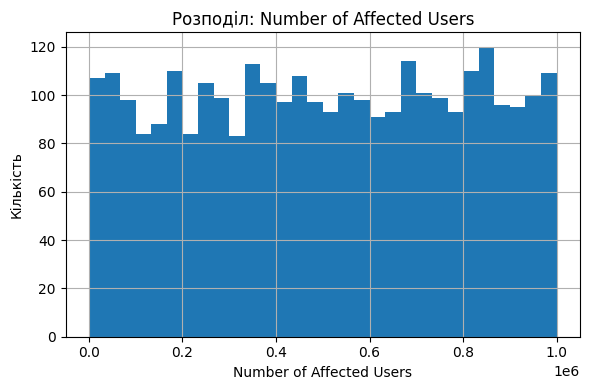

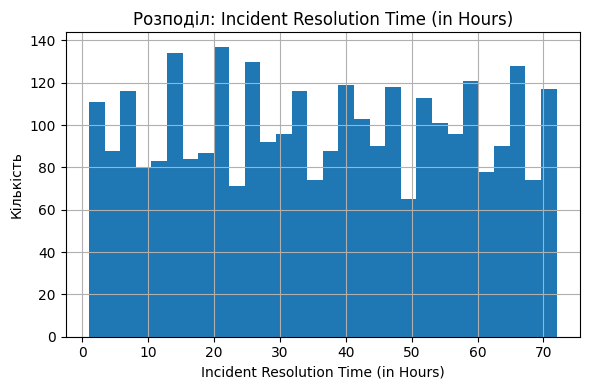

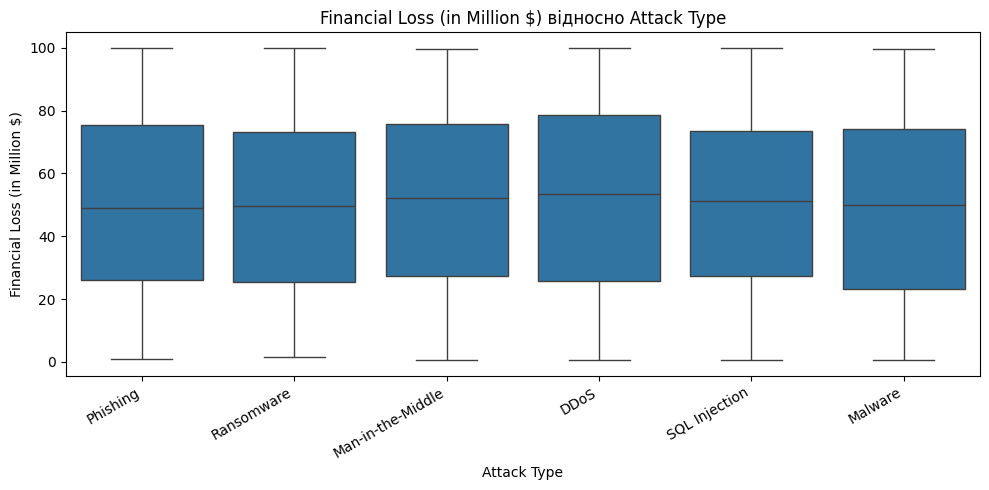

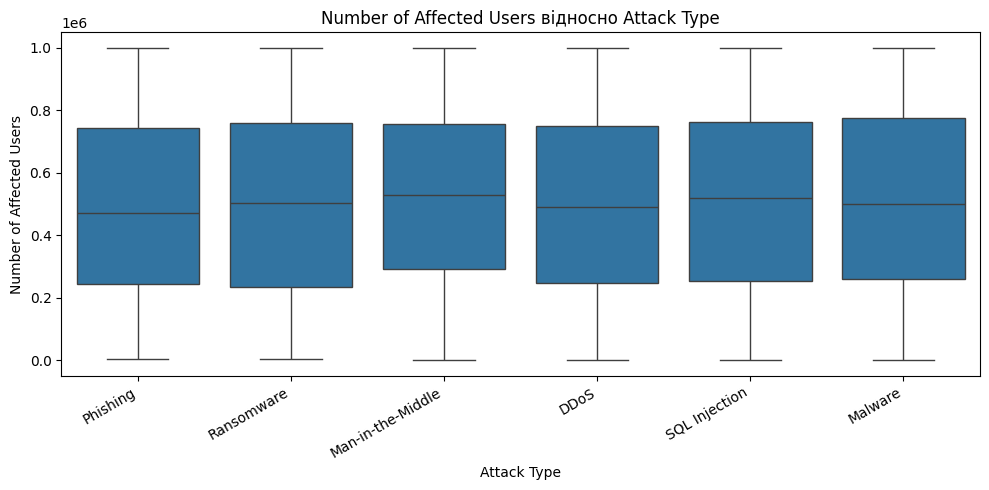

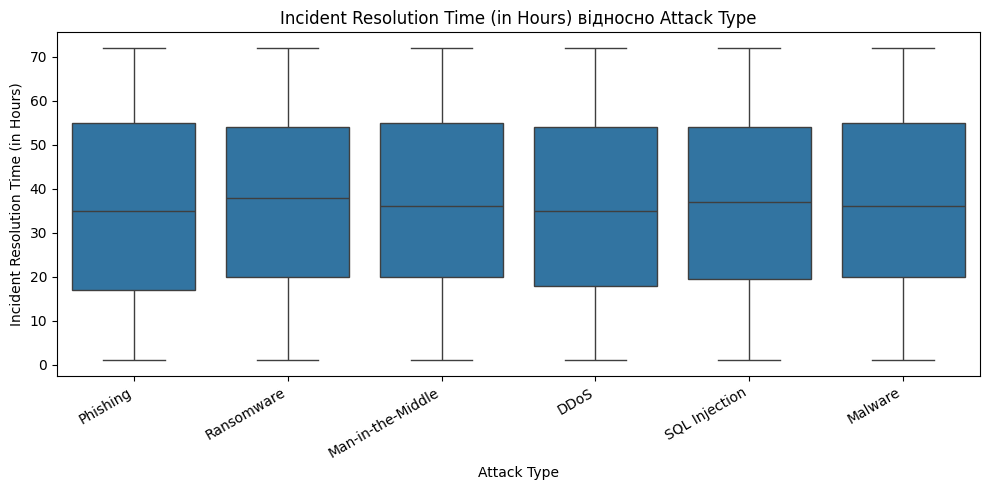

In [10]:
target_col = "Attack Type"
num_cols = [
    "Financial Loss (in Million $)",
    "Number of Affected Users",
    "Incident Resolution Time (in Hours)",
]

df_encoded = pd.get_dummies(df.drop(columns=["Year"]), drop_first=True)

attack_dummies = [c for c in df_encoded.columns if c.startswith(f"{target_col}_")]
heatmap_cols = num_cols + attack_dummies
corr = df_encoded[heatmap_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляційна матриця (числові ознаки + цільові one-hot)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

for col in num_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f"Розподіл: {col}")
    plt.xlabel(col)
    plt.ylabel("Кількість")
    plt.tight_layout()
    plt.show()

for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f"{col} відносно {target_col}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


# Step 4. Нормалізувати дані


In [11]:
target_col = "Attack Type"
X = df.drop(columns=["Year", target_col])
y = df[target_col]

# numeric / categorical splits
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # <-- fix
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2400, 33)
X_test shape: (600, 33)


# Step 5. Провести навчання наступних класифікаторів
- kNN
- дерево ухвалення рішень
- SVM
- Random Forest
- AdaBoost
- Підібрати оптимальні параметри для kNN, для SVM,
 за допомогою GridSearch підібрати оптимальні «C» і «gamma»
Серед обраних оптимальних моделей кожного класу вибрати найкращу.
Відобразити sklearn.metrics.classification_report і sklearn.metrics.confusion_matrix

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.17356139 0.13893443 0.16269301        nan 0.16321765
 0.14665214 0.15798304        nan 0.15942582 0.14560858 0.15695293
        nan 0.16479862 0.16742517 0.16364939        nan 0.16533906
 0.16080092 0.16067279        nan 0.16632349 0.16251629 0.16181008]
  warnings.warn(



================ kNN ================
Best params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
CV f1_macro: 0.1736
Test accuracy: 0.1767
Test f1_macro: 0.1764

classification_report:
                   precision    recall  f1-score   support

             DDoS       0.20      0.21      0.20       106
          Malware       0.18      0.16      0.17        97
Man-in-the-Middle       0.18      0.17      0.18        92
         Phishing       0.17      0.16      0.17       106
       Ransomware       0.19      0.21      0.20        99
    SQL Injection       0.13      0.14      0.14       100

         accuracy                           0.18       600
        macro avg       0.18      0.18      0.18       600
     weighted avg       0.18      0.18      0.18       600



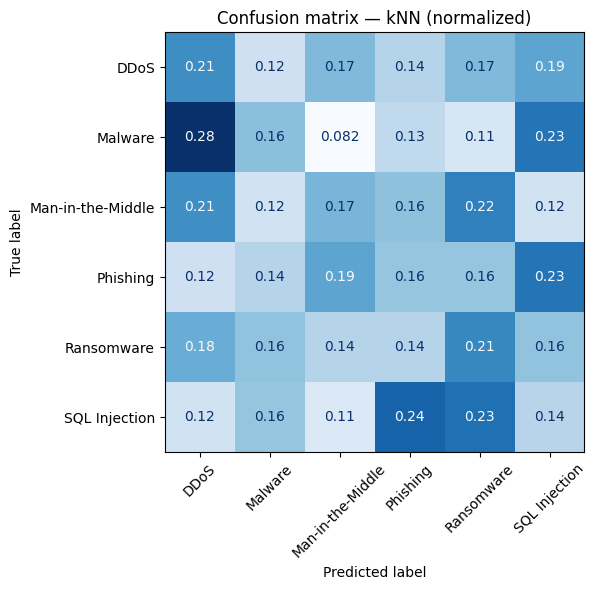


================ Decision Tree ================
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
CV f1_macro: 0.1824
Test accuracy: 0.1617
Test f1_macro: 0.1627

classification_report:
                   precision    recall  f1-score   support

             DDoS       0.19      0.16      0.17       106
          Malware       0.15      0.16      0.15        97
Man-in-the-Middle       0.12      0.17      0.14        92
         Phishing       0.17      0.15      0.16       106
       Ransomware       0.21      0.17      0.19        99
    SQL Injection       0.17      0.15      0.16       100

         accuracy                           0.16       600
        macro avg       0.17      0.16      0.16       600
     weighted avg       0.17      0.16      0.16       600



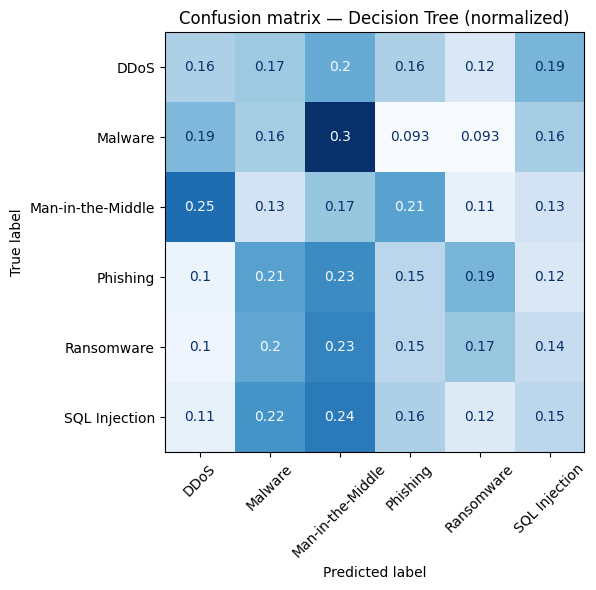


================ SVM (RBF) ================
Best params: {'clf__C': 100, 'clf__gamma': 'scale'}
CV f1_macro: 0.1730
Test accuracy: 0.1783
Test f1_macro: 0.1760

classification_report:
                   precision    recall  f1-score   support

             DDoS       0.17      0.24      0.20       106
          Malware       0.16      0.20      0.18        97
Man-in-the-Middle       0.20      0.18      0.19        92
         Phishing       0.17      0.14      0.16       106
       Ransomware       0.21      0.21      0.21        99
    SQL Injection       0.14      0.10      0.12       100

         accuracy                           0.18       600
        macro avg       0.18      0.18      0.18       600
     weighted avg       0.18      0.18      0.18       600



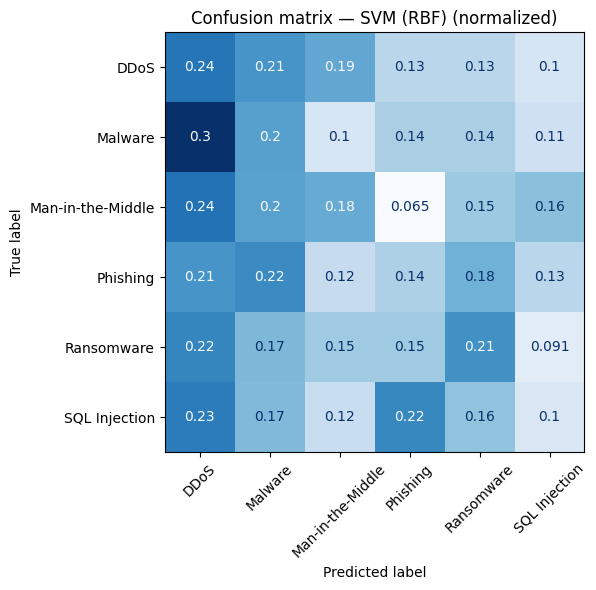


================ Random Forest ================
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
CV f1_macro: 0.1779
Test accuracy: 0.1733
Test f1_macro: 0.1717

classification_report:
                   precision    recall  f1-score   support

             DDoS       0.18      0.19      0.19       106
          Malware       0.16      0.14      0.15        97
Man-in-the-Middle       0.17      0.20      0.18        92
         Phishing       0.23      0.24      0.23       106
       Ransomware       0.16      0.16      0.16        99
    SQL Injection       0.12      0.11      0.11       100

         accuracy                           0.17       600
        macro avg       0.17      0.17      0.17       600
     weighted avg       0.17      0.17      0.17       600



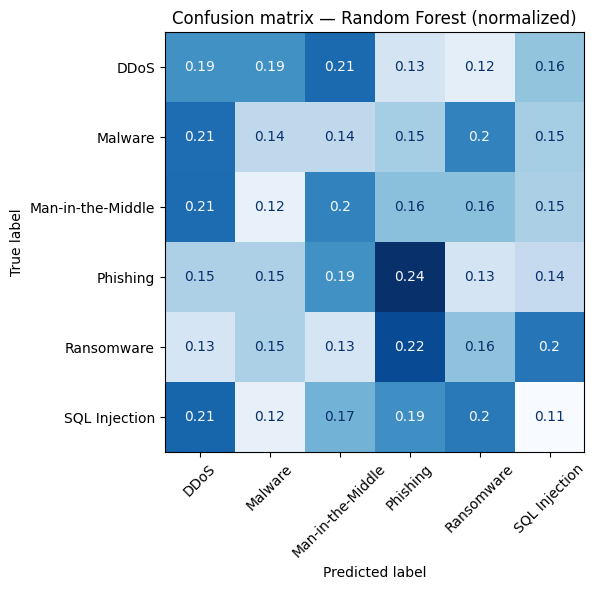


================ AdaBoost ================
Best params: {'clf__learning_rate': 1.5, 'clf__n_estimators': 100}
CV f1_macro: 0.1780
Test accuracy: 0.1650
Test f1_macro: 0.1545

classification_report:
                   precision    recall  f1-score   support

             DDoS       0.15      0.18      0.16       106
          Malware       0.14      0.10      0.12        97
Man-in-the-Middle       0.06      0.04      0.05        92
         Phishing       0.22      0.31      0.26       106
       Ransomware       0.18      0.22      0.20        99
    SQL Injection       0.20      0.11      0.14       100

         accuracy                           0.17       600
        macro avg       0.16      0.16      0.15       600
     weighted avg       0.16      0.17      0.16       600



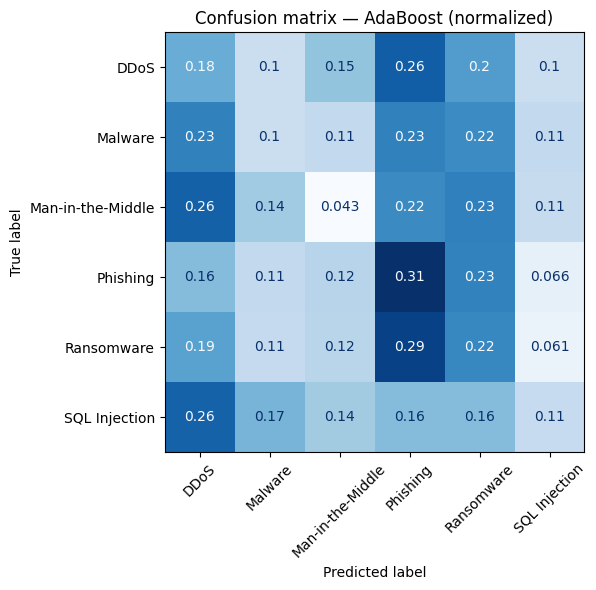


>>> Best by CV f1_macro: Decision Tree (0.1824)
>>> Best by TEST f1_macro: kNN (0.1764)


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORING = "f1_macro"   # good for multi-class & imbalance

def fit_eval(pipe, param_grid, name):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1,
        verbose=0,
    )
    gs.fit(X_train_raw, y_train)  # raw data; pipeline handles preprocessing
    best = gs.best_estimator_
    y_pred = best.predict(X_test_raw)

    print(f"\n================ {name} ================")
    print("Best params:", gs.best_params_)
    print(f"CV {SCORING}: {gs.best_score_:.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test f1_macro: {f1_score(y_test, y_pred, average='macro'):.4f}\n")

    print("classification_report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix (normalized by true counts for readability)
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best.classes_)
    fig, ax = plt.subplots(figsize=(7, 6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    ax.set_title(f"Confusion matrix — {name} (normalized)")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "model": best,
        "cv_score": gs.best_score_,
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
    }

results = []

# kNN — tune n_neighbors, weights, distance (p)
pipe_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier())])
grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}
results.append(fit_eval(pipe_knn, grid_knn, "kNN"))

# Decision Tree
pipe_dt = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))])
grid_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
}
results.append(fit_eval(pipe_dt, grid_dt, "Decision Tree"))

# SVM (RBF) — REQUIRED: tune C and gamma
pipe_svm = Pipeline([("prep", preprocessor), ("clf", SVC(kernel="rbf", class_weight="balanced"))])
grid_svm = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
}
results.append(fit_eval(pipe_svm, grid_svm, "SVM (RBF)"))

# Random Forest
pipe_rf = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))])
grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}
results.append(fit_eval(pipe_rf, grid_rf, "Random Forest"))

# AdaBoost
pipe_ada = Pipeline([("prep", preprocessor), ("clf", AdaBoostClassifier(random_state=42))])
grid_ada = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.5, 1.0, 1.5],
}
results.append(fit_eval(pipe_ada, grid_ada, "AdaBoost"))

# --------- pick overall best by CV f1_macro (or change to test_f1_macro) ----------
best_by_cv = max(results, key=lambda r: r["cv_score"])
best_by_test = max(results, key=lambda r: r["test_f1_macro"])

print("\n>>> Best by CV f1_macro:", best_by_cv["name"], f"({best_by_cv['cv_score']:.4f})")
print(">>> Best by TEST f1_macro:", best_by_test["name"], f"({best_by_test['test_f1_macro']:.4f})")
